In [134]:
import pandas as pd
#from h3 import h3
import glob
import numpy as np
from pandas import merge
import json
#import geopandas as gpd
import matplotlib.pyplot as plt
#from shapely.geometry import shape
from datetime import datetime, timedelta
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn_extra.cluster import KMedoids

In [135]:
pd.set_option('display.max_columns', None)


# Datei einlesen
supply_at_midnight = pd.read_csv('sharenow_supply_data_6mo.csv')

# Config
HEX_RES = 7  # Hexagon Auflösung (siehe uber h3 library)
MIN_CHARGE_LEVEL = 50 # Wenn SoC unter 50% => Auto muss geladen werden

# 1. Wir bauen ein Dataframe, um alle möglichen Hexagon und Datum Kombinationen zu ermitteln. 
all_hexagons = pd.DataFrame(supply_at_midnight["hex_end_{}".format(HEX_RES)].unique(), columns=["hex_end_{}".format(HEX_RES)])
all_dates = pd.DataFrame(supply_at_midnight["date_start"].unique(), columns=["date_start"])

all_hexagons["key"] = 1
all_dates["key"] = 1

template = pd.merge(all_hexagons, all_dates, on=["key"])

template.drop(columns={"key"}, inplace=True)

# 2. In jedem Hexagon für jeden Tag ermitteln wir die Anzahl der Fahrzeuge, die gelanden werden müssen zum Stichzeitpunkt (00.00h)
low_charge_vehicles = supply_at_midnight[supply_at_midnight["fuel_end"]<MIN_CHARGE_LEVEL].groupby(["date_start", "hex_end_{}".format(HEX_RES)])["id"].count().reset_index()

# 3. Wir verschmelzen das Template Data Frame mit den tatsächlichen zu ladenden Fahrzeugen pro Hexagon x Datum
result = pd.merge(template, low_charge_vehicles, on = ["hex_end_7", "date_start"], how="left")

# Hexagon Datum Kombinationen, wo es keine Fahrzeuge gibt, die man laden muss, setzen wir auf 0.
# Hätten wir dieses "template" Dataframe nicht, könnten wir die "0" Fälle nicht ermitteln.
result.fillna(0, inplace=True)

# Spaltenname aussagekräftiger machen
result = result.rename(columns={"id":"number_of_low_soc_vehicle"})


# Ab hier Szenarien bestimmen...

# 2 Calculate Distribution

In [136]:
# We estimate a Multinomial Distribution
# Calculate Fleet Size per day (n_{k})
fleet_sizes_per_day = result.groupby(["date_start"]).agg({"number_of_low_soc_vehicle":"sum"}).reset_index()
fleet_sizes_per_day = fleet_sizes_per_day.rename(columns={"number_of_low_soc_vehicle":"total_number_of_low_soc_vehicle"})

# Sum_k^K n_{k} 
fleet_size_overall = fleet_sizes_per_day[["total_number_of_low_soc_vehicle"]].sum(axis=0)["total_number_of_low_soc_vehicle"]


## 2.1 Supply Generation 

In [137]:
# p_i for low battery vehicles for multinomial distribution
low_soc_vehicles_coefficients = (result.groupby(["hex_end_{}".format(HEX_RES)]).agg({"number_of_low_soc_vehicle":"sum"})/fleet_size_overall).reset_index()
low_soc_vehicles_coefficients.rename(columns={"number_of_low_soc_vehicle":"prob"}, inplace=True)

# Sort Values
low_soc_vehicles_coefficients = low_soc_vehicles_coefficients.sort_values(by=["hex_end_{}".format(HEX_RES)])

# Convert Probabilities to Numpy Array
low_soc_vehicles_prob_array = low_soc_vehicles_coefficients["prob"].to_numpy()


## 2.2. Sample Scenarios

In [138]:
# Example 
low_soc_vehicle_sample = np.random.multinomial(1000, low_soc_vehicles_prob_array) # No of vehicles to be charged

In [139]:
NO_HEXAGONS = low_soc_vehicle_sample.shape[0]

In [140]:
# This is the sorting we are using for the coefficients 
SORTED_HEXAGONS = low_soc_vehicles_coefficients["hex_end_{}".format(HEX_RES)]

In [141]:
NO_SCENARIOS = 1000

scenarios = np.empty(shape=[NO_SCENARIOS, NO_HEXAGONS])

In [142]:
# Generate the number of vehicles to be charged
# MLE for poisson distribution 
# MLE Estimator = 1/n * Sum D_t (Di demand at day t, n = 145 Days) (average demand per day)
poisson_mle_vehicles = fleet_sizes_per_day["total_number_of_low_soc_vehicle"].mean()

NO_OF_VEHICLES_TO_BE_CHARGED = np.random.poisson(poisson_mle_vehicles, NO_SCENARIOS)

In [143]:
for i in range(0, NO_SCENARIOS):
    low_soc_vehicle_sample = np.random.multinomial(NO_OF_VEHICLES_TO_BE_CHARGED[i], low_soc_vehicles_prob_array)
    scenarios[i] = low_soc_vehicle_sample

### 2.2.1 Clustering

In [144]:
km = KMeans(
    n_clusters=3, init='random',
    n_init=10, max_iter=300, 
    tol=1e-04, random_state=0
)
y_km = km.fit_predict(scenarios)


### 2.2.2. Identification of Clusters 

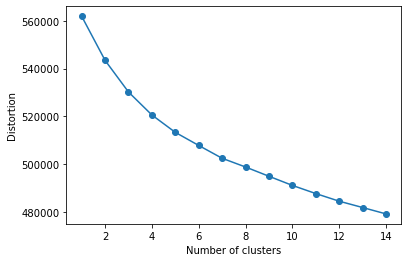

In [145]:
# calculate distortion for a range of number of cluster
NO_CLUSTER = 15
distortions = []
for i in range(1, NO_CLUSTER):
    km = KMeans(
        n_clusters=i, init='k-means++',
        n_init=10, max_iter=300,
        tol=1e-04, random_state=0
    )
    km.fit(scenarios)
    distortions.append(km.inertia_)

# plot
plt.plot(range(1, NO_CLUSTER), distortions, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Distortion')
plt.show()

### 2.2.2.1. K-Medoids Clusterings 

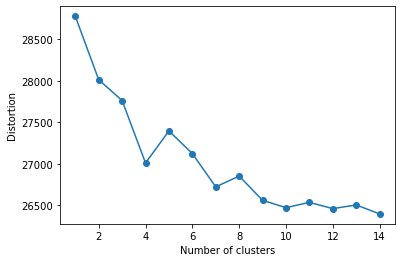

In [146]:
# calculate distortion for a range of number of cluster
NO_CLUSTER = 15
distortions = []
for i in range(1, NO_CLUSTER):
    kmedoids = KMedoids(n_clusters=i, init='k-medoids++', random_state = 0).fit(scenarios)
    distortions.append(kmedoids.inertia_)

# plot
plt.plot(range(1, NO_CLUSTER), distortions, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Distortion')
plt.show()


### 2.2.3. Alternative Strategy using real world data as scenarios

In [147]:
from sklearn_extra.cluster import KMedoids
# Use Real World Data to Reduce Scenario
days = result["date_start"].unique()
days.sort()

NO_RL_SCENARIOS = days.shape[0]

real_scenarios = np.empty(shape=[NO_RL_SCENARIOS, NO_HEXAGONS])

idx = 0
for day in days:
    supply_at_day = result[result["date_start"] == day].sort_values(by=["hex_end_{}".format(HEX_RES)])
    supply_arr = supply_at_day["number_of_low_soc_vehicle"].to_numpy()
    real_scenarios[idx] = supply_arr
    idx += 1

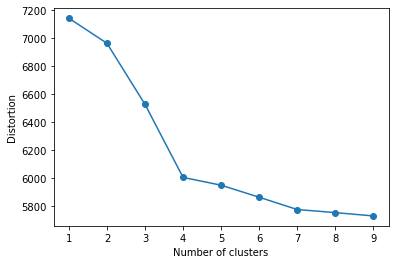

In [148]:
# calculate distortion for a range of number of cluster
NO_CLUSTER = 10
distortions = []
for i in range(1, NO_CLUSTER):
    kmedoids = KMedoids(n_clusters=i, init='k-medoids++', random_state=0).fit(real_scenarios)
    distortions.append(kmedoids.inertia_)

# plot
plt.plot(range(1, NO_CLUSTER), distortions, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Distortion')
plt.show()

## 2.3. Scenario Extraction

### 2.3.1. Extraction from Generated Scenarios 

In [149]:
kmedoids = KMedoids(n_clusters= 4, init='k-medoids++', random_state = 0).fit(scenarios)

In [150]:
# Access with index 0-3
kmedoids.cluster_centers_

array([[ 1.,  0.,  0.,  6.,  0.,  4.,  0.,  0.,  0.,  4.,  0.,  0.,  1.,
         3.,  0.,  2., 23., 13.,  5., 12., 23.,  3.,  0.,  1., 11.,  2.,
         7.,  1.,  1., 11.,  8.,  2.,  0.,  0.,  1.,  0.,  0.,  0.,  3.,
         2.,  7., 14.,  3.,  1., 11., 17.,  9., 10., 17., 13., 12.,  0.,
         1.,  0., 13., 16.,  6., 19.,  2., 12.,  1.,  0.,  0.,  7.,  5.,
         5., 16.,  0.,  0.,  4.,  4.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,
         0., 23., 14., 22.,  5., 20.,  5., 20.,  0.,  3.,  2.,  1.,  3.,
         3.,  0., 24.,  5.,  3., 13.],
       [ 1.,  1.,  0.,  6.,  0.,  6.,  0.,  0.,  0.,  3.,  0.,  0.,  0.,
         1.,  0.,  4., 23., 11.,  4., 14., 17.,  4.,  0.,  0., 11.,  0.,
         3.,  1.,  2.,  9., 14.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  1.,
         1.,  7., 12.,  1.,  2.,  7., 19., 11., 11., 14., 22., 12.,  0.,
         4.,  0.,  6., 17.,  5., 16., 10., 19.,  1.,  0.,  0.,  5.,  4.,
         9., 10.,  0.,  0.,  4., 10.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,
         1.,

In [151]:
# Assignment of scenarios to clusters
prediction = kmedoids.predict(scenarios)

In [152]:
unique, counts = np.unique(prediction, return_counts=True)
N = sum(counts)
dict(zip(unique, counts/N))

{0: 0.254, 1: 0.34, 2: 0.312, 3: 0.094}

In [153]:
df_multinomial = pd.DataFrame(kmedoids.cluster_centers_, columns=SORTED_HEXAGONS)
df_multinomial["probs"] = counts/N
df_multinomial.to_csv("scenarios_multinomial.csv",index=False)

In [154]:
df_multinomial

hex_end_7,871f18840ffffff,871f18841ffffff,871f18868ffffff,871f18869ffffff,871f1886affffff,871f1886bffffff,871f1896bffffff,871f18b01ffffff,871f18b02ffffff,871f18b04ffffff,871f18b05ffffff,871f18b06ffffff,871f18b0bffffff,871f18b0dffffff,871f18b11ffffff,871f18b20ffffff,871f18b21ffffff,871f18b22ffffff,871f18b23ffffff,871f18b24ffffff,871f18b25ffffff,871f18b26ffffff,871f18b28ffffff,871f18b29ffffff,871f18b2cffffff,871f18b2dffffff,871f18b2effffff,871f18b30ffffff,871f18b31ffffff,871f18b34ffffff,871f18b35ffffff,871f18b36ffffff,871f18b64ffffff,871f18b71ffffff,871f18b72ffffff,871f18b76ffffff,871f1d413ffffff,871f1d41bffffff,871f1d480ffffff,871f1d481ffffff,871f1d482ffffff,871f1d483ffffff,871f1d485ffffff,871f1d486ffffff,871f1d488ffffff,871f1d489ffffff,871f1d48affffff,871f1d48bffffff,871f1d48cffffff,871f1d48dffffff,871f1d48effffff,871f1d491ffffff,871f1d494ffffff,871f1d495ffffff,871f1d498ffffff,871f1d499ffffff,871f1d49affffff,871f1d49bffffff,871f1d49cffffff,871f1d49dffffff,871f1d49effffff,871f1d4a1ffffff,871f1d4a3ffffff,871f1d4a8ffffff,871f1d4a9ffffff,871f1d4aaffffff,871f1d4abffffff,871f1d4acffffff,871f1d4adffffff,871f1d4aeffffff,871f1d4b0ffffff,871f1d4b1ffffff,871f1d4b2ffffff,871f1d4b3ffffff,871f1d4b5ffffff,871f1d4c0ffffff,871f1d4c2ffffff,871f1d4c4ffffff,871f1d4c6ffffff,871f1d4d0ffffff,871f1d4d1ffffff,871f1d4d2ffffff,871f1d4d3ffffff,871f1d4d4ffffff,871f1d4d5ffffff,871f1d4d6ffffff,871f1d4d8ffffff,871f1d4daffffff,871f1d4dcffffff,871f1d4ddffffff,871f1d4deffffff,871f1d4f0ffffff,871f1d4f1ffffff,871f1d4f2ffffff,871f1d4f3ffffff,871f1d4f4ffffff,871f1d4f6ffffff,probs
0,1.0,0.0,0.0,6.0,0.0,4.0,0.0,0.0,0.0,4.0,0.0,0.0,1.0,3.0,0.0,2.0,23.0,13.0,5.0,12.0,23.0,3.0,0.0,1.0,11.0,2.0,7.0,1.0,1.0,11.0,8.0,2.0,0.0,0.0,1.0,0.0,0.0,0.0,3.0,2.0,7.0,14.0,3.0,1.0,11.0,17.0,9.0,10.0,17.0,13.0,12.0,0.0,1.0,0.0,13.0,16.0,6.0,19.0,2.0,12.0,1.0,0.0,0.0,7.0,5.0,5.0,16.0,0.0,0.0,4.0,4.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,23.0,14.0,22.0,5.0,20.0,5.0,20.0,0.0,3.0,2.0,1.0,3.0,3.0,0.0,24.0,5.0,3.0,13.0,0.254
1,1.0,1.0,0.0,6.0,0.0,6.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,1.0,0.0,4.0,23.0,11.0,4.0,14.0,17.0,4.0,0.0,0.0,11.0,0.0,3.0,1.0,2.0,9.0,14.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,7.0,12.0,1.0,2.0,7.0,19.0,11.0,11.0,14.0,22.0,12.0,0.0,4.0,0.0,6.0,17.0,5.0,16.0,10.0,19.0,1.0,0.0,0.0,5.0,4.0,9.0,10.0,0.0,0.0,4.0,10.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,31.0,14.0,20.0,7.0,16.0,7.0,16.0,0.0,5.0,0.0,1.0,4.0,5.0,2.0,26.0,2.0,3.0,17.0,0.340
2,0.0,1.0,0.0,3.0,0.0,3.0,0.0,0.0,0.0,5.0,0.0,0.0,3.0,3.0,0.0,2.0,24.0,11.0,6.0,16.0,16.0,3.0,0.0,0.0,9.0,0.0,2.0,0.0,1.0,6.0,14.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,5.0,10.0,15.0,1.0,2.0,8.0,14.0,10.0,13.0,13.0,15.0,14.0,0.0,2.0,0.0,9.0,19.0,5.0,10.0,8.0,9.0,3.0,0.0,1.0,6.0,7.0,11.0,8.0,0.0,0.0,6.0,3.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,2.0,28.0,13.0,19.0,8.0,17.0,6.0,22.0,0.0,4.0,0.0,2.0,3.0,3.0,1.0,28.0,6.0,3.0,17.0,0.312
3,0.0,0.0,0.0,3.0,0.0,1.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,4.0,0.0,2.0,27.0,4.0,3.0,15.0,14.0,2.0,0.0,2.0,8.0,1.0,6.0,0.0,0.0,10.0,17.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,5.0,10.0,11.0,1.0,1.0,4.0,19.0,9.0,8.0,15.0,17.0,8.0,0.0,2.0,0.0,15.0,24.0,5.0,14.0,11.0,13.0,4.0,0.0,0.0,8.0,8.0,7.0,13.0,0.0,0.0,3.0,9.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,2.0,25.0,11.0,24.0,3.0,18.0,5.0,14.0,0.0,5.0,1.0,0.0,2.0,5.0,1.0,27.0,5.0,2.0,11.0,0.094


### 2.3.2. Extraction from Real World Data

In [155]:
kmedoids_real_scenario = KMedoids(n_clusters=4, init='k-medoids++', random_state=0).fit(real_scenarios)

In [156]:
# Access with index 0-3
kmedoids_real_scenario.cluster_centers_

array([[ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  1.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,
         0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  1.,  0.,  0.,  1.,  0.,
         0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.],
       [ 1.,  0.,  0., 12.,  0.,  4.,  0.,  0.,  0.,  6.,  0.,  2.,  0.,
         3.,  0.,  2., 27.,  9.,  4.,  8., 18.,  5.,  0.,  4.,  6.,  0.,
         8.,  0.,  1., 12., 13.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,
         3.,  7., 22.,  0.,  0.,  8., 10., 11.,  3., 16., 19., 17.,  0.,
         0.,  0., 14., 23.,  5., 20.,  6., 10.,  2.,  0.,  2.,  7.,  5.,
         9., 12.,  0.,  0.,  5.,  8.,  0.,  1.,  1.,  0.,  0.,  0.,  0.,
         0.,

In [157]:
# Assignment of scenarios to clusters
prediction_real_scenario = kmedoids_real_scenario.predict(real_scenarios)

In [158]:
prediction_real_scenario

array([1, 1, 1, 3, 3, 3, 1, 1, 1, 1, 3, 3, 3, 1, 1, 1, 1, 3, 3, 1, 1, 1,
       1, 1, 3, 3, 1, 1, 1, 1, 3, 3, 3, 3, 1, 1, 1, 1, 3, 3, 1, 1, 1, 2,
       1, 3, 3, 1, 2, 1, 2, 1, 3, 3, 1, 1, 2, 2, 2, 3, 3, 1, 1, 1, 2, 1,
       3, 3, 1, 1, 2, 1, 1, 3, 3, 2, 1, 1, 2, 1, 3, 3, 2, 2, 2, 2, 2, 3,
       3, 3, 3, 3, 3, 1, 3, 3, 1, 1, 2, 1, 1, 1, 3, 1, 1, 0, 2, 3, 2, 2,
       2, 2, 2, 1, 3, 1, 1, 2, 2, 2, 2, 3, 1, 2, 2, 2, 2, 2, 3, 2, 2, 2,
       2, 2, 3, 3, 2, 2, 2, 2, 1, 2, 3, 3, 1, 2, 2, 2, 3, 3, 2, 1, 2, 2,
       2, 3, 3, 1, 1, 1, 2, 2, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 0],
      dtype=int64)

In [159]:
unique, counts = np.unique(prediction_real_scenario, return_counts=True)
N = sum(counts)
dict(zip(unique, counts/N))

{0: 0.011560693641618497,
 1: 0.3815028901734104,
 2: 0.3236994219653179,
 3: 0.2832369942196532}

## Also create a function to simulate different SoCs

In [160]:
dfSoC = supply_at_midnight[supply_at_midnight["fuel_end"]<MIN_CHARGE_LEVEL].groupby(["date_start", "hex_end_{}".format(HEX_RES)])['fuel_end'].mean()
dfSoC = dfSoC.reset_index()

Round to 5% Steps

In [161]:
stepSize = 5
dfSoC['fuel_end'] = stepSize*round(dfSoC['fuel_end']/stepSize)

<AxesSubplot:xlabel='fuel_end', ylabel='count'>

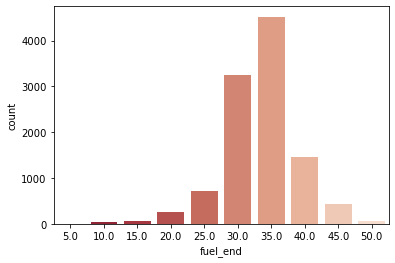

In [162]:
sns.countplot(data=dfSoC,x='fuel_end',palette=sns.color_palette("RdBu", 24))

In [163]:
SoC_List = []
numberScenarios = 6

hexagons = SORTED_HEXAGONS
for hex in hexagons:
    df = dfSoC[dfSoC['hex_end_7'] ==hex]
    dfProbability = pd.DataFrame(df['fuel_end'].value_counts()/len(df))
    dfProbability = dfProbability.reset_index()
    dfProbability.columns = ['soc','probability']

    if len(df) > 0:
        SoC_List.append(np.random.choice(dfProbability['soc'], numberScenarios, p=dfProbability['probability'])*0.01)
    else:
        SoC_List.append(np.ones(numberScenarios))

dfSoC = pd.DataFrame(SoC_List)

In [164]:
dfSoC

,0,1,2,3,4,5
0,0.15,0.35,0.40,0.40,0.15,0.40
1,0.20,0.35,0.15,0.35,0.25,0.30
2,1.00,1.00,1.00,1.00,1.00,1.00
3,0.40,0.25,0.35,0.40,0.30,0.30
4,1.00,1.00,1.00,1.00,1.00,1.00
...,...,...,...,...,...,...
92,0.35,0.30,0.30,0.35,0.15,0.15
93,0.35,0.35,0.30,0.35,0.35,0.35
94,0.35,0.35,0.35,0.40,0.35,0.30
95,0.40,0.35,0.30,0.20,0.30,0.40


In [165]:
dfSoC.to_csv('SoC_6.csv',index=False)

# Prices


### Load Price Data

In [166]:
dfAuctionData2019 = pd.read_csv("auction_spot_germany_luxembourg_2019.csv",sep=';',skiprows=1).reset_index()
dfAuctionData2020 = pd.read_csv("auction_spot_germany_luxembourg_2020.csv",sep=';',skiprows=1).reset_index()

dfAuctionData2019["Date"] = pd.to_datetime(dfAuctionData2019["Delivery day"],format="%d.%m.%Y")
dfAuctionData2020["Date"] = pd.to_datetime(dfAuctionData2020["Delivery day"],format="%d.%m.%Y")

dfAuctionData2019.head()

,index,Delivery day,Hour1,Hour2,Hour3A,Hour3B,Hour4,Hour5,Hour6,Hour7,Hour8,Hour9,Hour10,Hour11,Hour12,Hour13,Hour14,Hour15,Hour16,Hour17,Hour18,Hour19,Hour20,Hour21,Hour22,Hour23,Hour24,Minimum,Maximum,Volume Weighted Average,Middle Night\r\n(01-04),Early Morning\r\n(05-08),Late Morning\r\n(09-12),Early Afternoon\r\n(13-16),Rush Hour\r\n(17-20),Off-Peak 2\r\n(21-24),Baseload\r\n(01-24),Peakload\r\n(09-20),Night\r\n(01-06),Off-Peak 1\r\n(01-08),Business\r\n(09-16),Off-Peak\r\n(01-08 & 21-24),Morning\r\n(07-10),High Noon\r\n(11-14),Afternoon\r\n(15-18),Evening\r\n(19-24),Sun Peak\r\n(11-16),Date
0,0,31.12.2019,"24,14","22,12","13,01",NaN,"4,97","9,81","18,37","23,50","27,17","36,56","40,43","32,22","38,98","38,60","37,90","38,00","39,58","42,28","46,06","47,73","46,00","42,20","39,74","38,88","37,39","4,97","47,73","32,41","16,06","19,71","37,05","38,52","45,52","39,55","32,74","40,36","15,40","17,89","37,78","25,11","31,92","36,93","41,48","41,99","37,55",2019-12-31
1,1,30.12.2019,"11,07","11,84","6,16",NaN,"1,40","4,81","16,43","26,90","30,38","32,04","31,90","29,06","26,94","30,30","30,61","31,53","33,61","35,25","38,09","39,35","31,58","30,68","29,67","29,68","24,33","1,40","39,35","26,08","7,62","19,63","29,99","31,51","36,07","28,59","25,57","32,52","8,62","13,62","30,75","18,61","30,31","29,23","34,62","30,88","30,34",2019-12-30
2,2,29.12.2019,"30,60","28,10","26,92",NaN,"22,85","20,97","21,31","22,72","25,10","27,52","30,04","30,60","30,93","32,03","30,61","30,80","32,86","33,97","39,53","41,16","39,60","38,14","32,00","30,11","25,52","20,97","41,16","30,17","27,12","22,53","29,77","31,58","38,57","31,44","30,17","33,30","25,13","24,82","30,67","27,03","26,35","31,04","34,29","34,42","31,31",2019-12-29
3,3,28.12.2019,"30,17","29,50","29,43",NaN,"28,20","28,53","27,40","29,20","31,63","34,61","36,82","35,61","35,05","34,70","33,78","34,91","35,86","39,86","40,79","43,75","43,29","39,62","35,39","34,75","30,17","27,40","43,75","34,42","29,33","29,19","35,52","34,81","41,92","34,98","34,29","37,42","28,87","29,26","35,17","31,17","33,07","34,79","37,86","37,83","34,99",2019-12-28
4,4,27.12.2019,"31,17","30,02","28,67",NaN,"28,70","29,19","31,03","33,10","38,89","38,55","40,00","40,00","40,47","40,15","40,41","42,20","45,13","46,53","49,38","44,88","43,99","39,52","36,67","35,38","33,57","28,67","49,38","38,19","29,64","33,05","39,76","41,97","46,20","36,29","37,82","42,64","29,80","31,35","40,86","32,99","37,64","40,26","45,81","39,00","41,39",2019-12-27


### Only use Data between 22 and 04

In [167]:
hours = ["24","1","2","3A","4","5","6"]
attributeList = ["Date"]

for h in hours:
    attributeList.append("Hour{}".format(h))

dfAuctionData2019 = dfAuctionData2019[attributeList]
dfAuctionData2020 = dfAuctionData2020[attributeList]
dfAuctionData2019.head()

,Date,Hour24,Hour1,Hour2,Hour3A,Hour4,Hour5,Hour6
0,2019-12-31,"37,39","24,14","22,12","13,01","4,97","9,81","18,37"
1,2019-12-30,"24,33","11,07","11,84","6,16","1,40","4,81","16,43"
2,2019-12-29,"25,52","30,60","28,10","26,92","22,85","20,97","21,31"
3,2019-12-28,"30,17","30,17","29,50","29,43","28,20","28,53","27,40"
4,2019-12-27,"33,57","31,17","30,02","28,67","28,70","29,19","31,03"


### Use same dates as in mobility

In [168]:
resultUnique = result["date_start"].unique()

#Format Date
usedDates = pd.to_datetime(resultUnique,format='%Y%m%d')
dfUsedDates = pd.DataFrame(usedDates,columns=["Date"])

#Join single years
dfUsedDates2019 = dfUsedDates.merge(dfAuctionData2019,on="Date",how="inner")
dfUsedDates2020 = dfUsedDates.merge(dfAuctionData2020,on="Date",how="inner")

#Concat both years
dfUsedDates = pd.concat([dfUsedDates2019,dfUsedDates2020]).reset_index().drop('index',axis=1)
dfUsedDates.head()

,Date,Hour24,Hour1,Hour2,Hour3A,Hour4,Hour5,Hour6
0,2019-11-22,"34,35","35,30","34,72","35,73","35,94","35,59","37,24"
1,2019-11-24,"39,80","13,15","19,22","13,28","14,89","10,19","7,57"
2,2019-11-25,"41,58","38,19","36,30","36,02","35,40","35,38","37,84"
3,2019-11-26,"37,74","39,07","38,43","36,20","35,91","35,98","38,01"
4,2019-12-18,"32,19","21,95","25,39","26,35","26,04","28,39","30,19"


### Round prices to to cent

In [169]:
columns = list(dfUsedDates.columns)
columns.remove("Date")

dfUsedDates_Rounded = dfUsedDates[["Date"]]
for column in columns:
    dfUsedDates_Rounded[column] = round(dfUsedDates[column].str.replace(",",".").astype(float),0)
    dfUsedDates_Rounded[column] = dfUsedDates_Rounded[column].astype(int)

    dfUsedDates_Rounded[column]
dfUsedDates_Rounded.head()

,Date,Hour24,Hour1,Hour2,Hour3A,Hour4,Hour5,Hour6
0,2019-11-22,34,35,35,36,36,36,37
1,2019-11-24,40,13,19,13,15,10,8
2,2019-11-25,42,38,36,36,35,35,38
3,2019-11-26,38,39,38,36,36,36,38
4,2019-12-18,32,22,25,26,26,28,30


## Use real data

## K-Means

In [170]:
dfUsedDates_Rounded_NoDate = dfUsedDates_Rounded.drop('Date',axis=1)

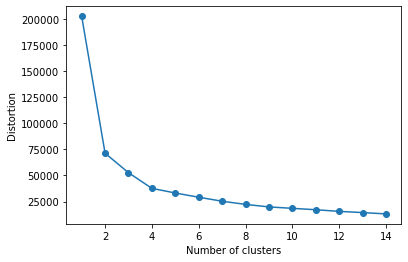

In [171]:
# calculate distortion for a range of number of cluster
NO_CLUSTER = 15
distortions = []
for i in range(1, NO_CLUSTER):
    km = KMeans(
        n_clusters=i, init='k-means++',
        n_init=10, max_iter=300,
        tol=1e-04, random_state=0
    )
    km.fit(dfUsedDates_Rounded_NoDate)
    distortions.append(km.inertia_)

# plot
plt.plot(range(1, NO_CLUSTER), distortions, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Distortion')
plt.show()

In [172]:
km = KMeans(
    n_clusters=2, init='random',
    n_init=10, max_iter=300, 
    tol=1e-04, random_state=0
)
km.fit(dfUsedDates_Rounded_NoDate)

KMeans(init='random', n_clusters=2, random_state=0)

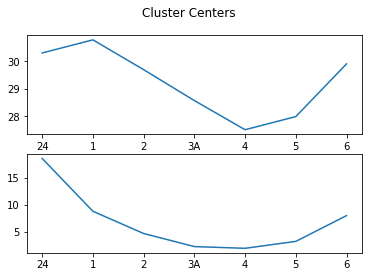

In [173]:
fig, axs = plt.subplots(2)
fig.suptitle('Cluster Centers')
axs[0].plot(hours,km.cluster_centers_[0])
axs[1].plot(hours,km.cluster_centers_[1])

### Probabilities

In [174]:
counts = pd.Series(km.predict(dfUsedDates_Rounded_NoDate)).value_counts()
probabilities = counts/counts.sum()
dfProbabilities = pd.DataFrame(list(zip(list(range(1,len(km.cluster_centers_)+1)),probabilities)),columns=["Scenario","Probability"])
dfProbabilities

,Scenario,Probability
0,1,0.710983
1,2,0.289017


In [175]:
dfPrices = pd.DataFrame(km.cluster_centers_,columns=hours)
dfPrices['Scenario'] =list(range(1,len(km.cluster_centers_)+1))
dfPrices

,24,1,2,3A,4,5,6,Scenario
0,30.308943,30.788618,29.699187,28.569106,27.504065,27.98374,29.910569,1
1,18.520000,8.760000,4.660000,2.240000,1.920000,3.20000,7.960000,2


In [176]:
dfMerge = dfProbabilities.merge(dfPrices,on="Scenario",how="inner")
dfMerge

,Scenario,Probability,24,1,2,3A,4,5,6
0,1,0.710983,30.308943,30.788618,29.699187,28.569106,27.504065,27.98374,29.910569
1,2,0.289017,18.520000,8.760000,4.660000,2.240000,1.920000,3.20000,7.960000


In [177]:
dfMerge.to_csv("priceScenarions1.csv",index=False)

## K-Medoids

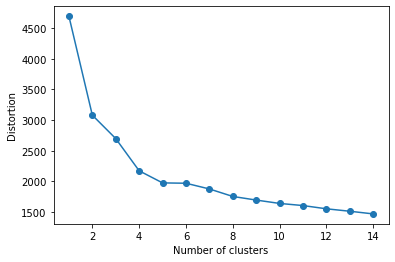

In [178]:
# calculate distortion for a range of number of cluster
NO_CLUSTER = 15
distortions = []
for i in range(1, NO_CLUSTER):
    kmedoids = KMedoids(n_clusters=i, init='k-medoids++', random_state = 0).fit(dfUsedDates_Rounded_NoDate)
    distortions.append(kmedoids.inertia_)

# plot
plt.plot(range(1, NO_CLUSTER), distortions, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Distortion')
plt.show()

In [179]:
y_km = KMedoids(
    n_clusters=4, init='k-medoids++',random_state=0
)
y_km.fit(dfUsedDates_Rounded_NoDate)

KMedoids(init='k-medoids++', n_clusters=4, random_state=0)

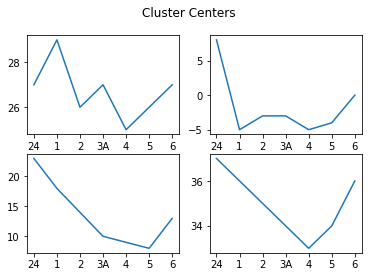

In [180]:
fig, axs = plt.subplots(2,2)
fig.suptitle('Cluster Centers')
axs[0,0].plot(hours,y_km.cluster_centers_[0])
axs[0,1].plot(hours,y_km.cluster_centers_[1])
axs[1,0].plot(hours,y_km.cluster_centers_[2])
axs[1,1].plot(hours,y_km.cluster_centers_[3])

### Probabilities

In [181]:
counts = pd.Series(y_km.predict(dfUsedDates_Rounded_NoDate)).value_counts()
probabilities = counts/counts.sum()
dfProbabilities = pd.DataFrame(list(zip(list(range(1,len(y_km.cluster_centers_)+1)),probabilities)),columns=["Scenario","Probability"])
dfProbabilities

,Scenario,Probability
0,1,0.450867
1,2,0.242775
2,3,0.190751
3,4,0.115607


In [182]:
dfPrices = pd.DataFrame(y_km.cluster_centers_,columns=hours)
dfPrices['Scenario'] =list(range(1,len(y_km.cluster_centers_)+1))
dfPrices

,24,1,2,3A,4,5,6,Scenario
0,27,29,26,27,25,26,27,1
1,8,-5,-3,-3,-5,-4,0,2
2,23,18,14,10,9,8,13,3
3,37,36,35,34,33,34,36,4


In [183]:
dfMerge = dfProbabilities.merge(dfPrices,on="Scenario",how="inner")
dfMerge

,Scenario,Probability,24,1,2,3A,4,5,6
0,1,0.450867,27,29,26,27,25,26,27
1,2,0.242775,8,-5,-3,-3,-5,-4,0
2,3,0.190751,23,18,14,10,9,8,13
3,4,0.115607,37,36,35,34,33,34,36


In [184]:
dfMerge.to_csv("priceScenarions2.csv",index=False)

## Consider whole Year (2019)

In [185]:
# curtail df and rename column Hour3A
dfAuctionData2019 = dfAuctionData2019.drop(columns=["Date"], errors="ignore")
dfAuctionData2019.rename(columns={"Hour3A":"Hour3"}, inplace=True)

# convert to floats
for col in dfAuctionData2019.columns:
    dfAuctionData2019[col] = pd.to_numeric(dfAuctionData2019[col].str.replace(",","."))
    
dfAuctionData2019.dropna(inplace=True)

In [186]:
dfAuctionData2019.corr()

,Hour24,Hour1,Hour2,Hour3,Hour4,Hour5,Hour6
Hour24,1.000000,0.462016,0.484147,0.500895,0.519340,0.531138,0.572754
Hour1,0.462016,1.000000,0.960905,0.932471,0.904818,0.882784,0.829898
Hour2,0.484147,0.960905,1.000000,0.981101,0.946991,0.923222,0.867616
Hour3,0.500895,0.932471,0.981101,1.000000,0.980984,0.956964,0.904647
Hour4,0.519340,0.904818,0.946991,0.980984,1.000000,0.980280,0.929358
Hour5,0.531138,0.882784,0.923222,0.956964,0.980280,1.000000,0.965219
Hour6,0.572754,0.829898,0.867616,0.904647,0.929358,0.965219,1.000000


In [187]:
import seaborn as sns
import matplotlib.pyplot as pyplot

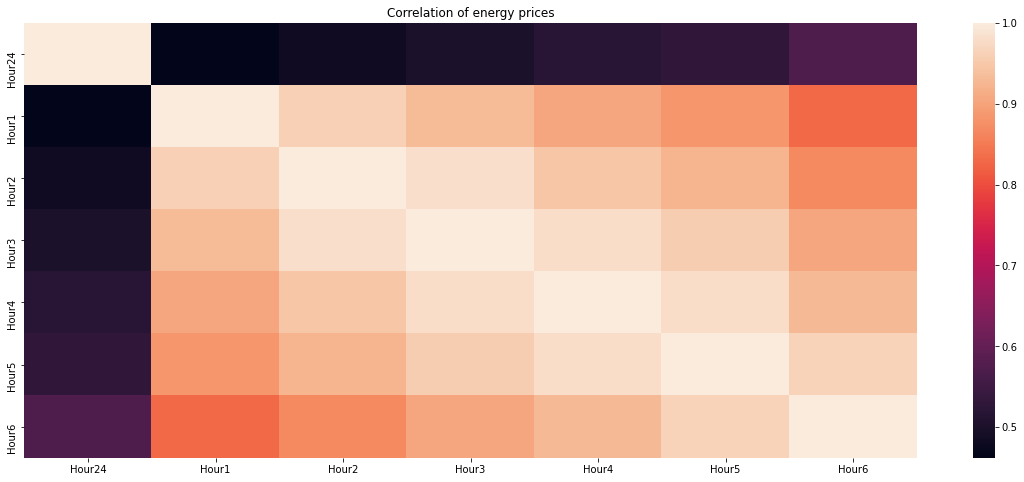

In [188]:
fig, ax = pyplot.subplots(figsize=(20, 8))
sns.heatmap(dfAuctionData2019.corr()).set_title('Correlation of energy prices')
fig.savefig("correlation_price.png")

#### k-Medoids

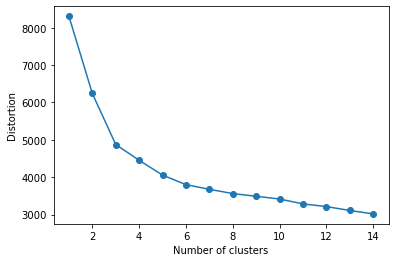

In [189]:
# calculate distortion for a range of number of cluster
from sklearn_extra.cluster import KMedoids
NO_CLUSTER = 15
distortions = []
for i in range(1, NO_CLUSTER):
    kmedoids = KMedoids(n_clusters=i, init='k-medoids++', random_state = 0).fit(dfAuctionData2019)
    distortions.append(kmedoids.inertia_)

# plot
plt.plot(range(1, NO_CLUSTER), distortions, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Distortion')
plt.show()

In [190]:
y_km = KMedoids(n_clusters=7, init='k-medoids++',random_state=0)
y_km.fit(dfAuctionData2019)

KMedoids(init='k-medoids++', n_clusters=7, random_state=0)

In [191]:
dfAuctionData2019

,Hour24,Hour1,Hour2,Hour3,Hour4,Hour5,Hour6
0,37.39,24.14,22.12,13.01,4.97,9.81,18.37
1,24.33,11.07,11.84,6.16,1.40,4.81,16.43
2,25.52,30.60,28.10,26.92,22.85,20.97,21.31
3,30.17,30.17,29.50,29.43,28.20,28.53,27.40
4,33.57,31.17,30.02,28.67,28.70,29.19,31.03
...,...,...,...,...,...,...,...
360,49.96,26.90,25.12,24.12,22.04,18.37,22.09
361,31.41,50.73,47.11,47.07,46.94,47.00,46.91
362,49.98,42.91,45.22,45.63,44.00,43.88,45.92
363,50.76,-33.57,-45.92,-48.29,-44.99,-48.93,-29.91


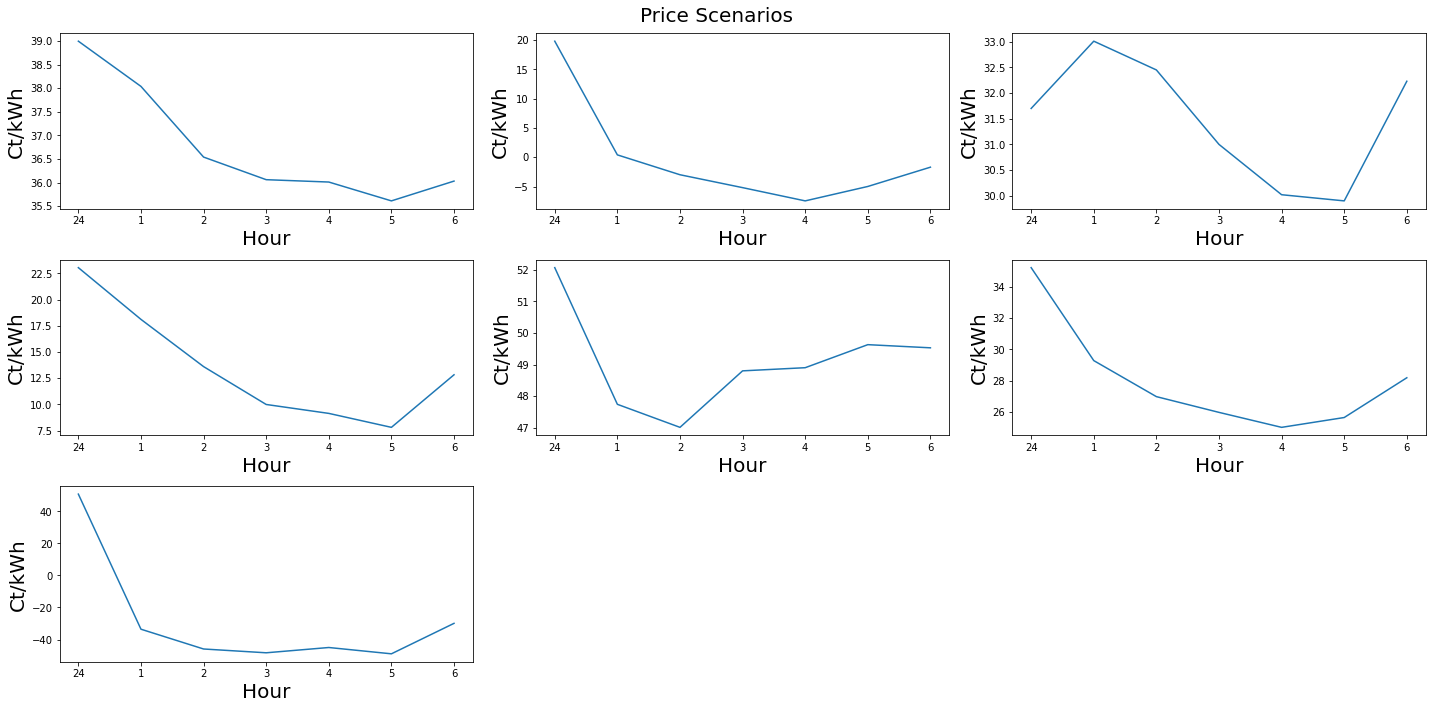

In [192]:
fig, axs = plt.subplots(3,3,figsize=(20,10))
fig.suptitle('Price Scenarios',fontsize=20)
hours[3] = '3'
axs[0,0].plot(hours,y_km.cluster_centers_[0])
axs[0,1].plot(hours,y_km.cluster_centers_[1])
axs[0,2].plot(hours,y_km.cluster_centers_[2])
axs[1,0].plot(hours,y_km.cluster_centers_[3])
axs[1,1].plot(hours,y_km.cluster_centers_[4])
axs[1,2].plot(hours,y_km.cluster_centers_[5])
axs[2,0].plot(hours,y_km.cluster_centers_[6])

axs[0,0].set_xlabel('Hour',fontsize=20)
axs[0,1].set_xlabel('Hour',fontsize=20)
axs[0,2].set_xlabel('Hour',fontsize=20)
axs[1,0].set_xlabel('Hour',fontsize=20)
axs[1,1].set_xlabel('Hour',fontsize=20)
axs[1,2].set_xlabel('Hour',fontsize=20)
axs[2,0].set_xlabel('Hour',fontsize=20)

axs[0,0].set_ylabel('Ct/kWh',fontsize=20)
axs[0,1].set_ylabel('Ct/kWh',fontsize=20)
axs[0,2].set_ylabel('Ct/kWh',fontsize=20)
axs[1,0].set_ylabel('Ct/kWh',fontsize=20)
axs[1,1].set_ylabel('Ct/kWh',fontsize=20)
axs[1,2].set_ylabel('Ct/kWh',fontsize=20)
axs[2,0].set_ylabel('Ct/kWh',fontsize=20)

fig.delaxes(axs[2,1])
fig.delaxes(axs[2,2])

fig.tight_layout() 
plt.savefig('price_scenarios.png')
plt.show()

In [193]:
counts = pd.Series(y_km.predict(dfAuctionData2019)).value_counts()
probabilities = counts/counts.sum()
dfProbabilities = pd.DataFrame(list(zip(list(range(1,len(y_km.cluster_centers_)+1)),probabilities)),columns=["Scenario","Probability"])
dfProbabilities

,Scenario,Probability
0,1,0.370879
1,2,0.233516
2,3,0.206044
3,4,0.082418
4,5,0.052198
5,6,0.049451
6,7,0.005495


In [194]:
dfPrices = pd.DataFrame(y_km.cluster_centers_,columns=hours)
dfPrices['Scenario'] =list(range(1,len(y_km.cluster_centers_)+1))
dfPrices

,24,1,2,3,4,5,6,Scenario
0,39.00,38.04,36.54,36.06,36.01,35.61,36.03,1
1,19.80,0.40,-2.99,-5.19,-7.45,-4.99,-1.70,2
2,31.70,33.01,32.45,31.00,30.02,29.90,32.23,3
3,23.04,18.11,13.61,10.00,9.15,7.82,12.83,4
4,52.07,47.74,47.01,48.80,48.90,49.63,49.53,5
5,35.24,29.28,26.97,25.96,25.00,25.63,28.18,6
6,50.76,-33.57,-45.92,-48.29,-44.99,-48.93,-29.91,7


In [195]:
dfMerge = dfProbabilities.merge(dfPrices,on="Scenario",how="inner")
dfMerge

,Scenario,Probability,24,1,2,3,4,5,6
0,1,0.370879,39.00,38.04,36.54,36.06,36.01,35.61,36.03
1,2,0.233516,19.80,0.40,-2.99,-5.19,-7.45,-4.99,-1.70
2,3,0.206044,31.70,33.01,32.45,31.00,30.02,29.90,32.23
3,4,0.082418,23.04,18.11,13.61,10.00,9.15,7.82,12.83
4,5,0.052198,52.07,47.74,47.01,48.80,48.90,49.63,49.53
5,6,0.049451,35.24,29.28,26.97,25.96,25.00,25.63,28.18
6,7,0.005495,50.76,-33.57,-45.92,-48.29,-44.99,-48.93,-29.91


In [196]:
dfMerge.to_csv("priceScenarions3.csv",index=False)